In [1]:
import numpy as np
import scipy.signal as signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
import re
import os

from enfify.enf_estimation import segmented_freq_estimation_DFT1, segmented_phase_estimation_hilbert
from enfify.preprocessing import downsample_ffmpeg, bandpass_filter, extract_number, cut_extract_number
from enfify.enf_enhancement import RFA, VMD

In [2]:
noise_fs, down_sig_noise = wavfile.read('/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/interim/ENF-WHU-Dataset/1min_noise/1min_noisy_down/down_min_003.wav')
cut_noise_fs, cut_down_sig_noise = wavfile.read('/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/interim/ENF-WHU-Dataset/1min_noise/1min_noisy_down_cut/down_cut_min_003.wav')
ref_fs, down_sig_ref = wavfile.read('/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/interim/ENF-WHU-Dataset/1min_ref/1min_enf_ref_data/min_003_ref.wav')

n_noise = np.arange(len(down_sig_noise))
n_noise_cut = np.arange(len(cut_down_sig_noise))
n_ref = np.arange(len(down_sig_ref))

print(noise_fs)
print(ref_fs)

1000
400


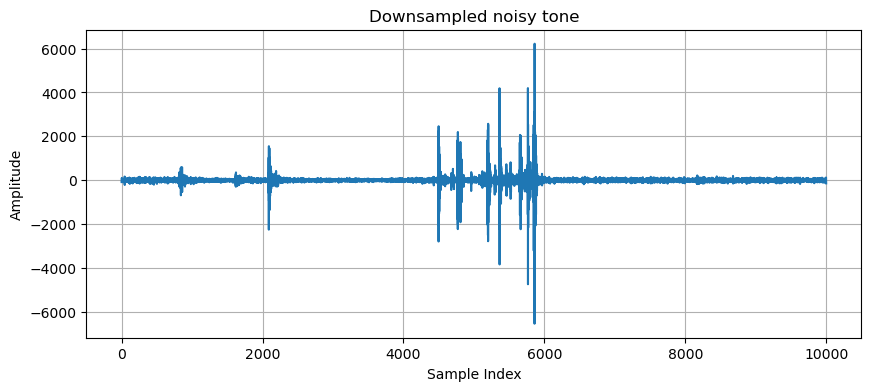

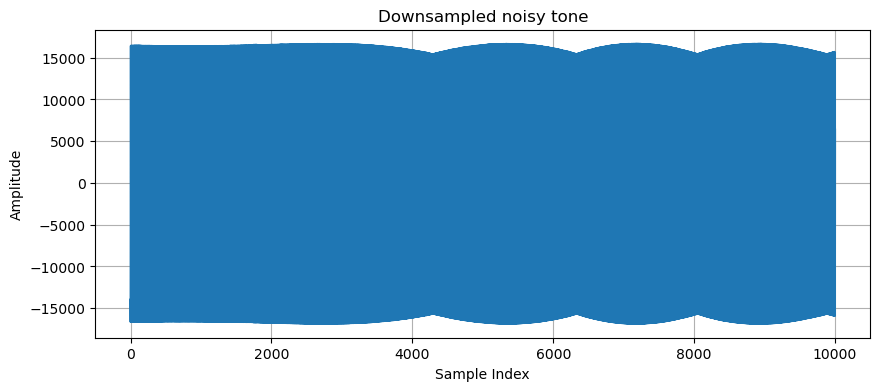

In [3]:
plt.figure(figsize=(10, 4))
plt.plot(n_noise[:10_000], down_sig_noise[:10_000])
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(n_ref[:10_000], down_sig_ref[:10_000])
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

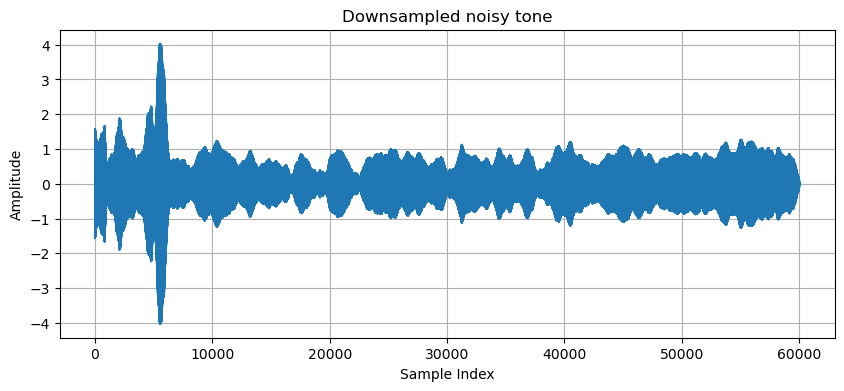

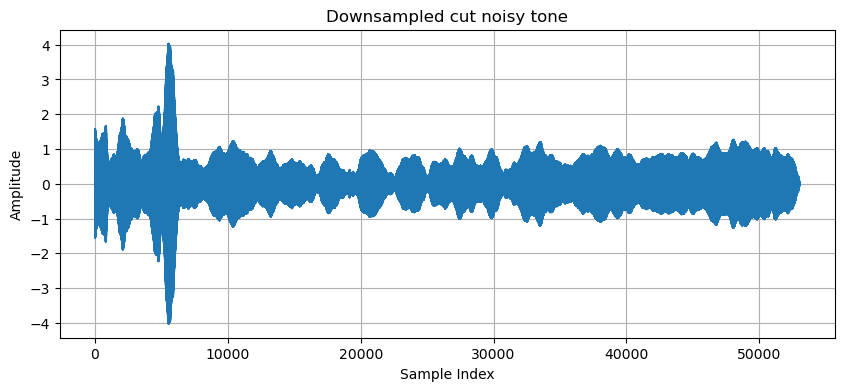

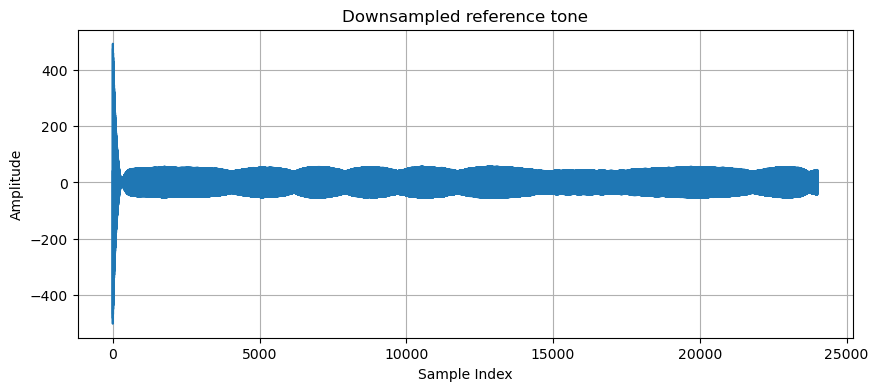

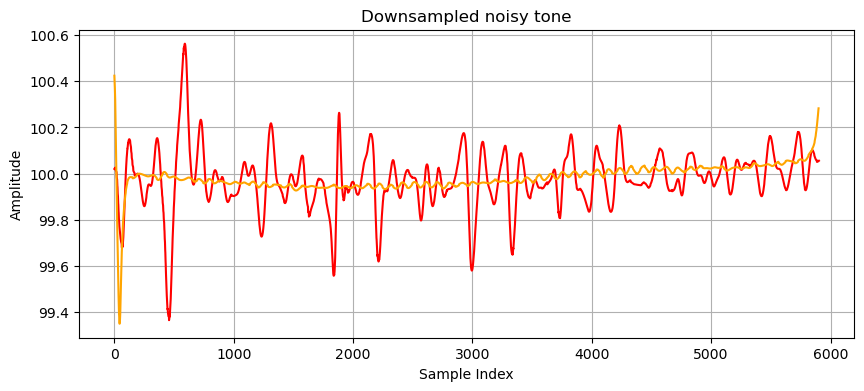

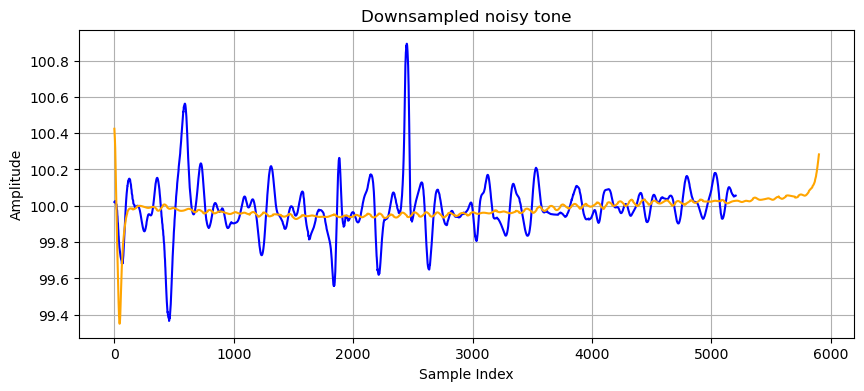

In [4]:
lowcut = 99.5
highcut = 100.5
bandpass_sig = bandpass_filter(down_sig_noise, lowcut, highcut, noise_fs, 1)
bandpass_sig_cut = bandpass_filter(cut_down_sig_noise, lowcut, highcut, noise_fs, 1)
bandpass_ref = bandpass_filter(down_sig_ref, lowcut, highcut, ref_fs, 1)

plt.figure(figsize=(10, 4))
plt.plot(n_noise, bandpass_sig)
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(n_noise_cut, bandpass_sig_cut)
plt.title('Downsampled cut noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(n_ref, bandpass_ref)
plt.title('Downsampled reference tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

freqs_DFT1_cut = segmented_freq_estimation_DFT1(bandpass_sig_cut, cut_noise_fs, 100, 20_000, 100)
freqs_DFT1 = segmented_freq_estimation_DFT1(bandpass_sig, noise_fs, 100, 20_000, 100)
freqs_ref = segmented_freq_estimation_DFT1(bandpass_ref, ref_fs, 100, 20_000, 100)

plt.figure(figsize=(10, 4))
plt.plot(freqs_DFT1, color="red")
plt.plot(freqs_ref, color="orange")
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(freqs_DFT1_cut, color="blue")
plt.plot(freqs_ref, color="orange")
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [5]:
for i in tqdm(range(5)):    
    alpha =  5000            # Balancing parameter of the data-fidelity constraint
    tau = 0                 # Noise-tolerance (no strict fidelity enforcement)
    n_mode = 1              # Number of modes to be recovered
    DC = 0
    tol =1e-7    # Tolerance of convergence criterion

    u_clean, _, _ = VMD(bandpass_sig, alpha, tau, n_mode, DC, tol)
    bandpass_sig = u_clean[0]

    u_clean_cut, _, _ = VMD(bandpass_sig_cut, alpha, tau, n_mode, DC, tol)
    bandpass_sig_cut = u_clean_cut[0]


100%|██████████| 5/5 [00:00<00:00, 10.26it/s]


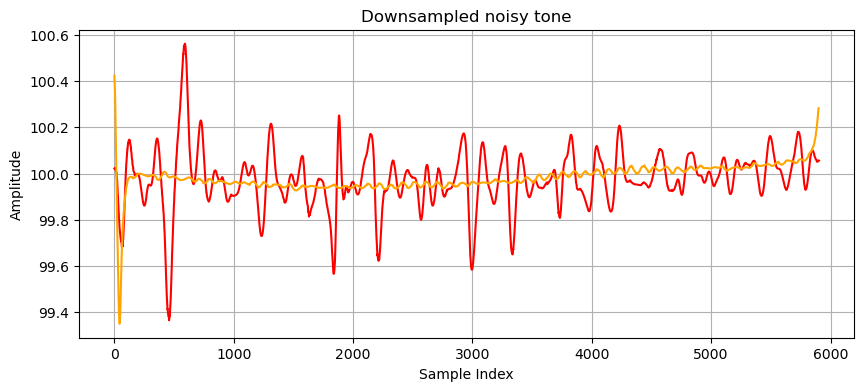

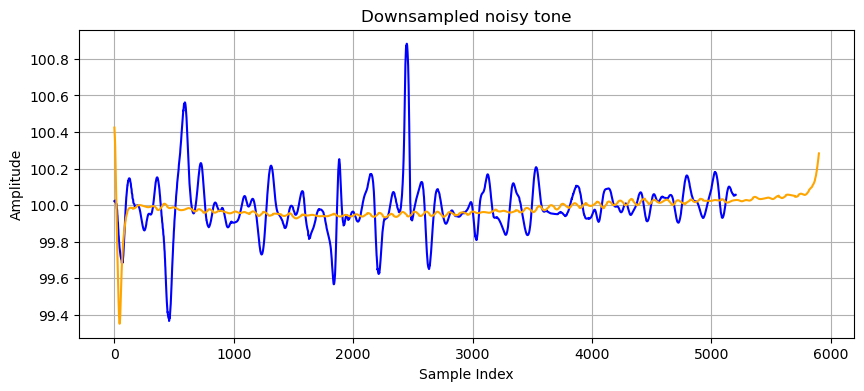

In [6]:
freqs_DFT1_cut = segmented_freq_estimation_DFT1(bandpass_sig_cut, cut_noise_fs, 100, 20_000, 100)
freqs_DFT1 = segmented_freq_estimation_DFT1(bandpass_sig, noise_fs, 100, 20_000, 100)
freqs_ref = segmented_freq_estimation_DFT1(bandpass_ref, ref_fs, 100, 20_000, 100)

plt.figure(figsize=(10, 4))
plt.plot(freqs_DFT1, color="red")
plt.plot(freqs_ref, color="orange")
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(freqs_DFT1_cut, color="blue")
plt.plot(freqs_ref, color="orange")
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

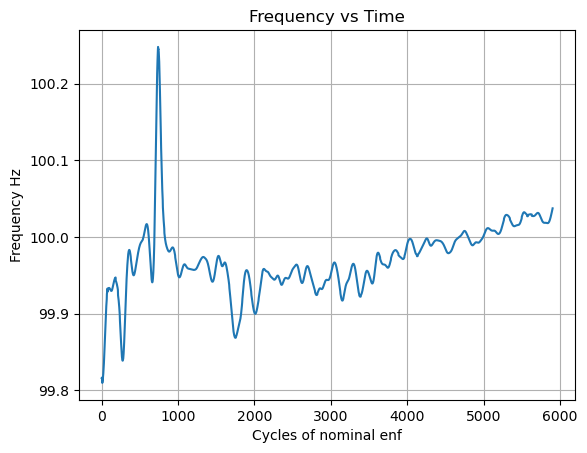

 33%|███▎      | 1/3 [00:14<00:28, 14.34s/it]

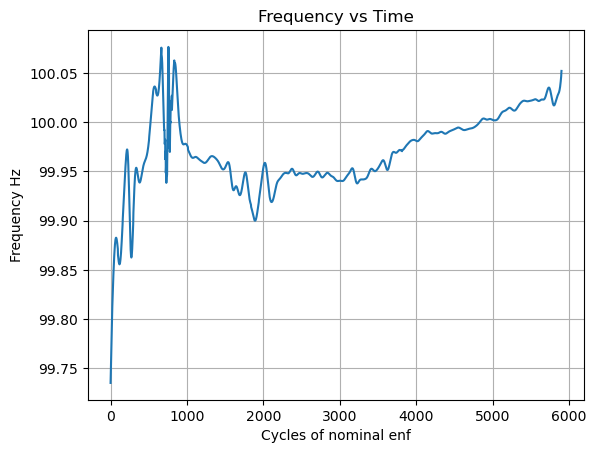

 67%|██████▋   | 2/3 [00:26<00:12, 12.97s/it]

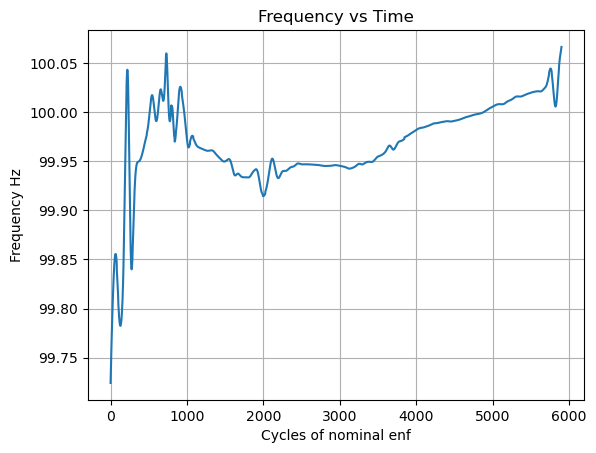

100%|██████████| 3/3 [00:38<00:00, 12.75s/it]


In [7]:
fs = noise_fs
f0 = 100
I = 3
epsilon = 1e-20
tau = int(2500)

denoised_signal = RFA(bandpass_sig, noise_fs, tau, epsilon, I, f0)

  0%|          | 0/2 [00:00<?, ?it/s]

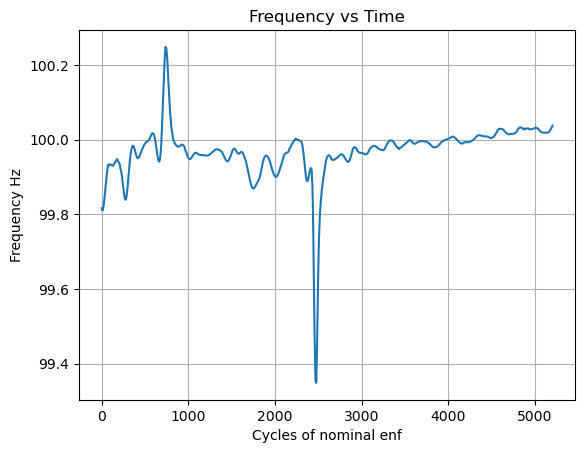

 50%|█████     | 1/2 [00:11<00:11, 11.20s/it]

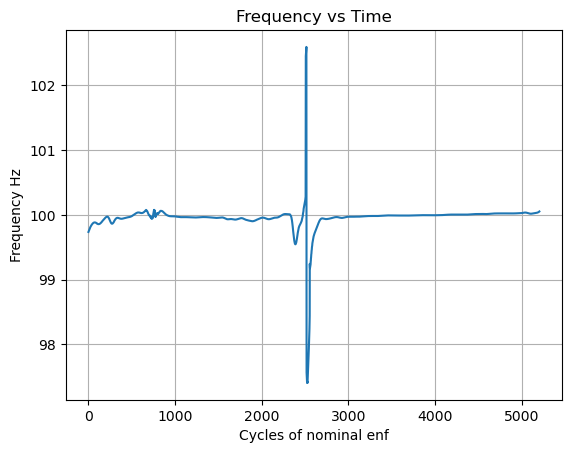

100%|██████████| 2/2 [00:21<00:00, 10.87s/it]


In [8]:
fs = noise_fs
f0 = 100
I = 2
epsilon = 1e-20
tau = int(2500)

cut_denoised_signal = RFA(bandpass_sig_cut, cut_noise_fs, tau, epsilon, I, f0)

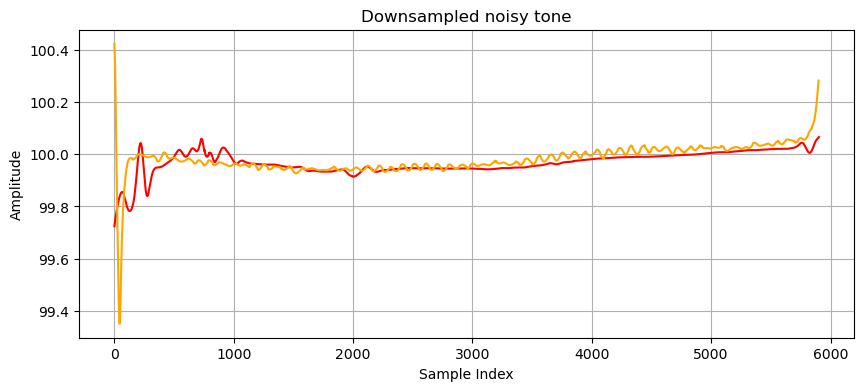

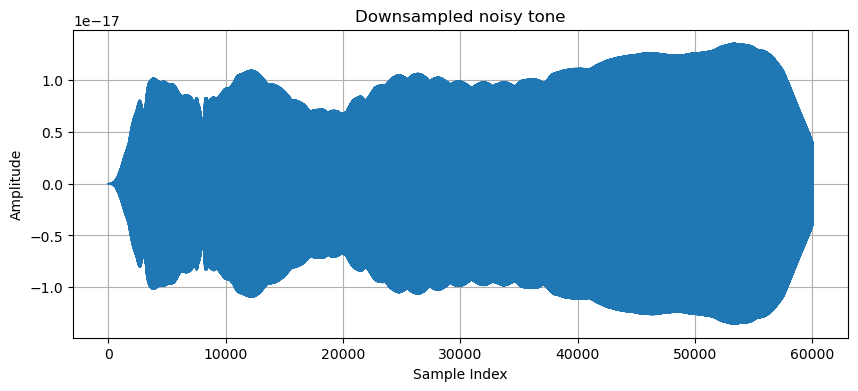

60032
60032


In [9]:
freqs_DFT1 = segmented_freq_estimation_DFT1(denoised_signal, noise_fs, 100, 20_000, 100)
freqs_ref = segmented_freq_estimation_DFT1(bandpass_ref, ref_fs, 100, 20_000, 100)

plt.figure(figsize=(10, 4))
plt.plot(freqs_DFT1, color="red")
plt.plot(freqs_ref, color="orange")
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(denoised_signal)
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

print(len(denoised_signal))
print(len(bandpass_sig))

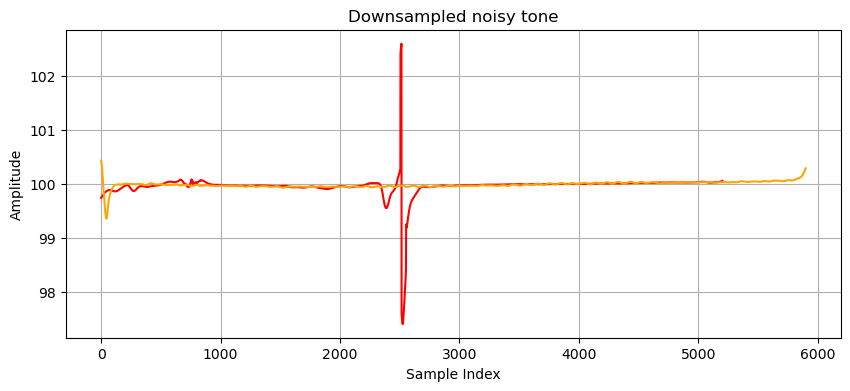

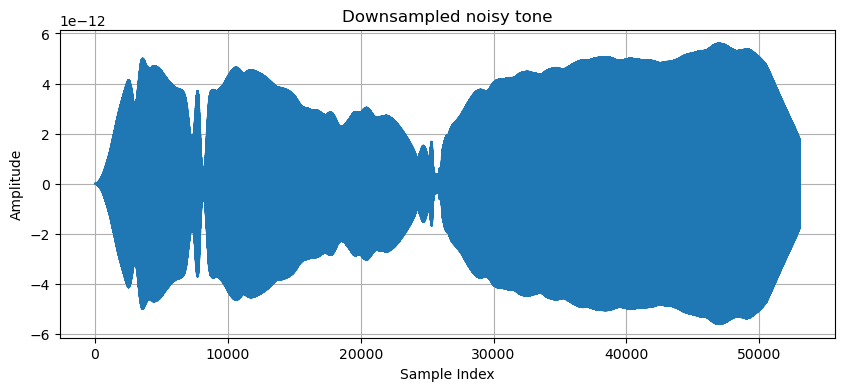

53032
53032


In [10]:
freqs_DFT1_cut = segmented_freq_estimation_DFT1(cut_denoised_signal, cut_noise_fs, 100, 20_000, 100)

plt.figure(figsize=(10, 4))
plt.plot(freqs_DFT1_cut, color="red")
plt.plot(freqs_ref, color="orange")
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(cut_denoised_signal)
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

print(len(cut_denoised_signal))
print(len(bandpass_sig_cut))

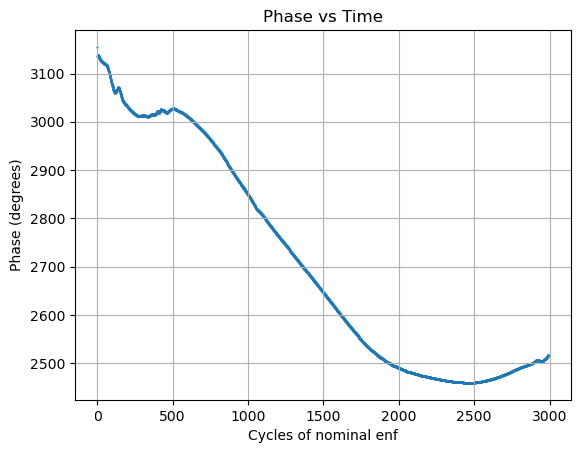

In [11]:
N_DFT = 20_000
NUM_CYCLES = 10

phases_denoised = segmented_phase_estimation_hilbert(denoised_signal, fs, NUM_CYCLES, 50)
phases_denoised = np.unwrap(phases_denoised)

x_denoised = np.arange(len(phases_denoised))
plt.scatter(x_denoised, np.degrees(phases_denoised), s= 0.5)
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

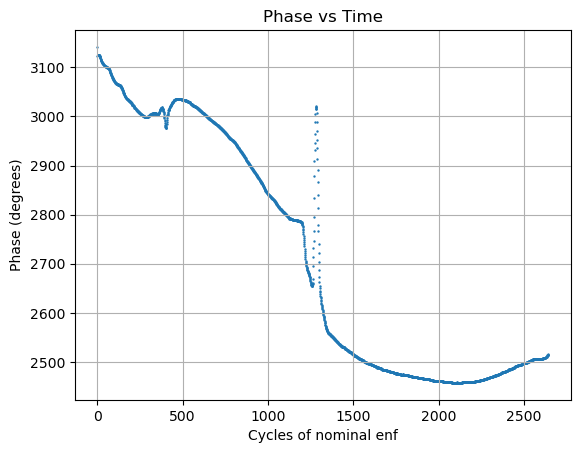

In [12]:
N_DFT = 20_000
NUM_CYCLES = 10

phases_denoised_cut = segmented_phase_estimation_hilbert(cut_denoised_signal, fs, NUM_CYCLES, 50)
phases_denoised_cut = np.unwrap(phases_denoised_cut)

x_denoised_cut = np.arange(len(phases_denoised_cut))
plt.scatter(x_denoised_cut, np.degrees(phases_denoised_cut), s= 0.5)
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

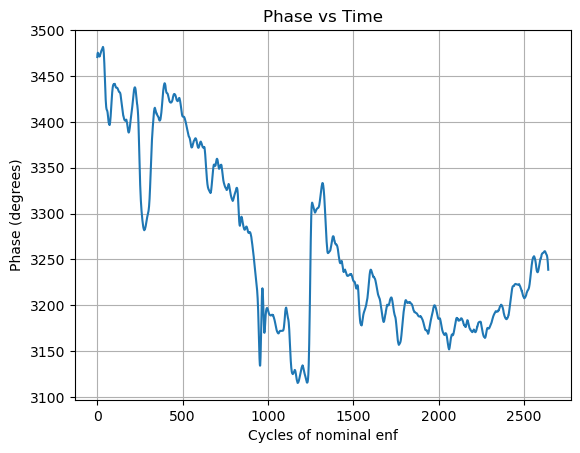

In [13]:
N_DFT = 20_000
NUM_CYCLES = 10

phases_cut = segmented_phase_estimation_hilbert(bandpass_sig_cut, fs, NUM_CYCLES, 50)
phases_cut = np.unwrap(phases_cut)

x_cut = np.arange(len(phases_cut))
plt.plot(x_cut, np.degrees(phases_cut))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

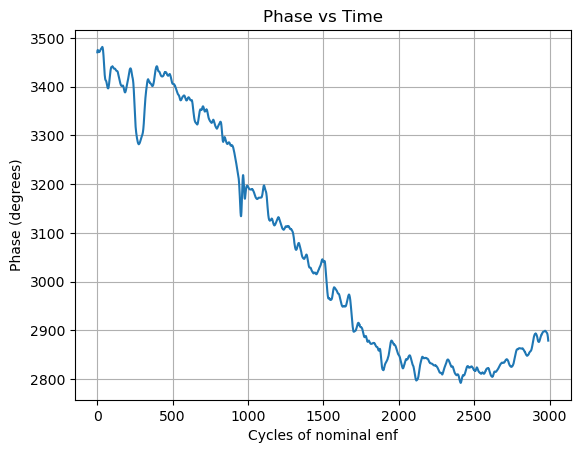

In [14]:
N_DFT = 20_000
NUM_CYCLES = 10

phases = segmented_phase_estimation_hilbert(bandpass_sig, fs, NUM_CYCLES, 50)
phases = np.unwrap(phases)

x = np.arange(len(phases))
plt.plot(x, np.degrees(phases))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

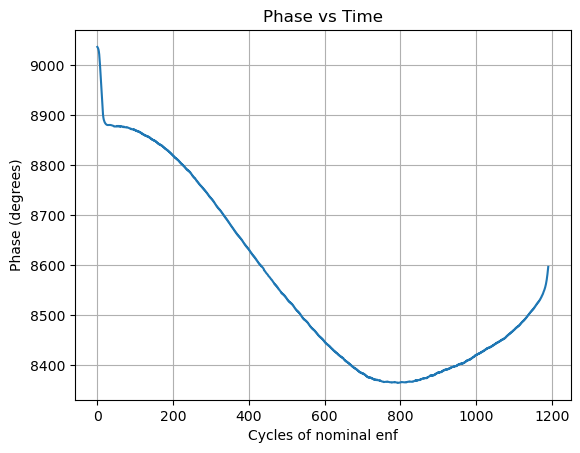

In [15]:
N_DFT = 20_000
NUM_CYCLES = 10

phases_ref = segmented_phase_estimation_hilbert(bandpass_ref, fs, NUM_CYCLES, 50)
phases_ref = np.unwrap(phases_ref)

x_ref = np.arange(len(phases_ref))
plt.plot(x_ref, np.degrees(phases_ref))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

In [16]:
def find_cut_in_phases(phases, x):
    """_summary_

    Args:
        phases (_type_): _description_
        x (_type_): _description_

    Returns:
        _type_: _description_
    """

    range_threshold = 20
    window_size = 10
    second_der = np.gradient(np.gradient(phases, x), x)

    plt.scatter(x, second_der, s=10)
    plt.xlabel("Cycles of nominal enf")
    plt.ylabel("second derivative")
    plt.title("Second derivative")
    plt.grid(True)
    plt.show()

    z_scores = np.abs(stats.zscore(second_der))
    outliers = np.array(np.where(z_scores > 5))

    plt.scatter(x, z_scores, s=10)
    plt.xlabel("Cycles of nominal enf")
    plt.ylabel("second derivative")
    plt.title("Second derivative")
    plt.grid(True)
    plt.show()

    if not np.any(outliers):
        return phases, x, outliers

    else:
        discontinuities = []
        i = 0

        while i < len(outliers[0]) - 1:
            start = outliers[0][i]
            while (
                i < len(outliers[0]) - 1
                and (outliers[0][i + 1] - outliers[0][i]) <= range_threshold
            ):
                i += 1
            end = outliers[0][i]

            # Search for the cut discontinuitites
            if end - start >= window_size:
                segment = second_der[start : end + 1]
                pos_count = np.sum(segment > 0)
                neg_count = np.sum(segment < 0)

                if pos_count > 0 and neg_count > 0:
                    discontinuities.append((start, end))

            i += 1

        discontinuities = np.array(discontinuities)

        if not np.any(discontinuities):
            return phases, x, discontinuities

        start = discontinuities[0][0]
        end = discontinuities[0][1]

        phases_new = phases[int(start) - 200 : int(end) + 200]
        x_new = x[int(start) - 200 : int(end) + 200]

        return phases_new, x_new, discontinuities

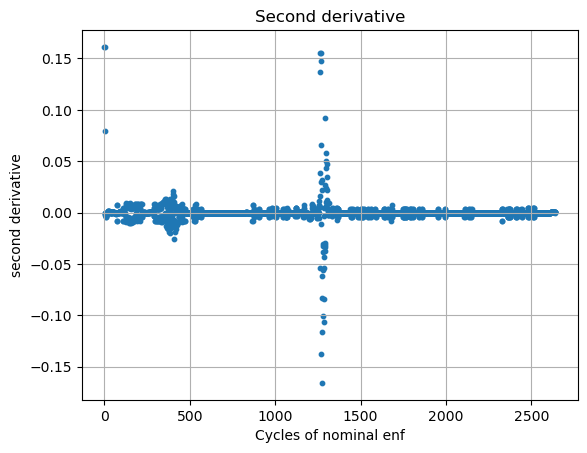

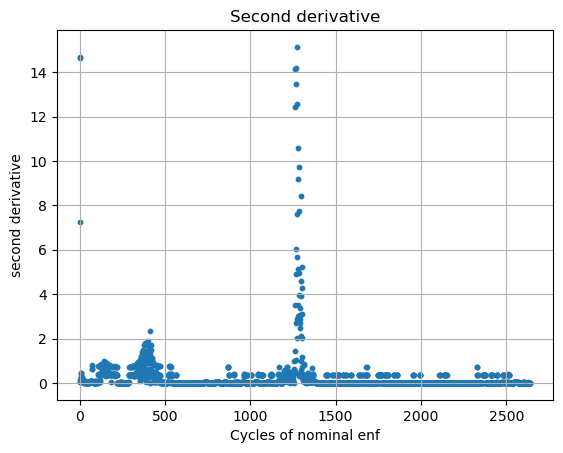

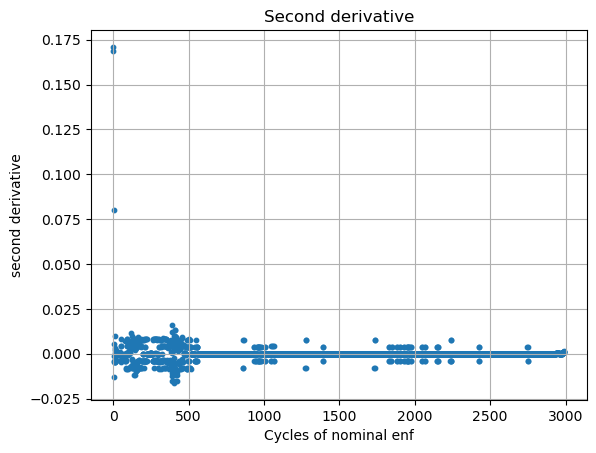

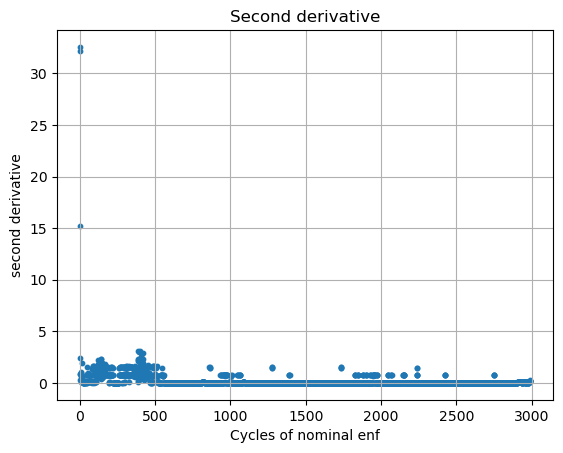

In [17]:
phases_cut, x_cut, cut_discontinuities = find_cut_in_phases(phases_denoised_cut, x_denoised_cut)
phases, x, discontinuities = find_cut_in_phases(phases_denoised, x_denoised)

In [18]:
import numpy as np
from scipy.io import wavfile
import os

from enfify.preprocessing import downsample_ffmpeg, bandpass_filter, extract_number, cut_extract_number
#from enfify.enf_enhancement import VMD, RFA

In [19]:
import numpy as np
import math
from enfify.enf_estimation import segmented_freq_estimation_DFT1
from tqdm import tqdm
from numba import jit, prange
from scipy.signal import get_window, windows
from scipy.fft import fft
import matplotlib.pyplot as plt

# ...........................RFA................................#

@jit(nopython=True, fastmath=True)
def z_SFM(sig, n, fs, alpha, tau):
    """Computes the z_SFM value with JIT optimization."""
    sum_sig = np.sum(sig[n - tau : n + tau + 1])
    z = np.exp(1j * 2 * np.pi * (1 / fs) * alpha * sum_sig)
    return z


@jit(nopython=True, parallel=True, fastmath=True)
def kernel_function(sig, f, n, fs, alpha, tau_values, tau_dash_values):
    """Computes the kernel function using JIT and vectorized operations."""
    auto_corr = np.empty(len(tau_values), dtype=np.complex128)
    auto_corr_dash = np.empty(len(tau_dash_values), dtype=np.complex128)

    for i in range(len(tau_values)):
        auto_corr[i] = z_SFM(sig, n, fs, alpha, tau_values[i])
        auto_corr_dash[i] = z_SFM(sig, n, fs, alpha, tau_dash_values[i])

    sin_vals = np.sin(2 * np.pi * (1 / fs) * f * tau_values)
    cos_vals = np.cos(2 * np.pi * (1 / fs) * f * tau_values)

    # Precompute exponents to save time in kernel calculation
    kernel = (auto_corr**sin_vals) * (auto_corr_dash**cos_vals)
    return np.angle(kernel)


@jit(nopython=True, parallel=True, fastmath=True)
def rfa_kernel_phases(sig, denoised_sig, Nx, f_start, fs, alpha, tau, tau_values, tau_dash_values):
    for n in prange(Nx - 1):
        f = f_start[n]
        kernel_phases = kernel_function(sig, f, n, fs, alpha, tau_values, tau_dash_values)
        denoised_sig[n] = np.sum(kernel_phases) / ((tau + 1) * tau * np.pi * alpha)

    return denoised_sig


def RFA(sig, fs, tau, epsilon, var_I, estimated_enf):
    """Optimized Recursive Frequency Adaptation algorithm with partial JIT optimization."""
    Nx = len(sig)
    alpha = 1 / (4 * fs * np.max(sig))
    f_start = estimated_enf * np.ones(Nx)
    tau_values = np.arange(1, tau + 1)
    tau_dash_values = tau_values + int(np.round(fs / (4 * estimated_enf)))

    for k in tqdm(range(var_I)):
        denoised_sig = np.zeros(Nx)

        denoised_sig = rfa_kernel_phases(
            sig, denoised_sig, Nx, f_start, fs, alpha, tau, tau_values, tau_dash_values
        )

        # Peak frequency estimation
        peak_freqs = segmented_freq_estimation_DFT1(
            denoised_sig, fs, num_cycles=10, N_DFT=20_000, nominal_enf=estimated_enf
        )

        '''
        plt.plot(peak_freqs)
        plt.xlabel("Cycles of nominal enf")
        plt.ylabel("Frequency Hz")
        plt.title("Frequency vs Time")
        plt.grid(True)
        plt.show()'''

        base_repeats = Nx // len(peak_freqs)
        remainder = Nx % len(peak_freqs)
        repeat_counts = np.full(len(peak_freqs), base_repeats)
        repeat_counts[:remainder] += 1
        new_freqs = np.repeat(peak_freqs, repeat_counts)

        f_diff = new_freqs - f_start
        f_start = new_freqs

        val = np.sum(f_diff**2) / np.sum(f_start**2)

        if val <= epsilon:
            return denoised_sig

        sig = denoised_sig  # Update the signal for the next iteration

    return denoised_sig

In [20]:
# ...................................Variational Mode Decomposition 2...................................#
def VMD_2(signal, alpha, tau, num_modes, enforce_DC, tolerance):
    """Variational Mode Decomposition (VMD)

    Args:
        signal (array): Input signal.
        alpha (float): Regularization parameter for the modes.
        tau (float): Time-step for dual ascent.
        num_modes (int): Number of modes to extract.
        enforce_DC (bool): Whether to enforce a DC component.
        tolerance (float): Convergence tolerance.

    Returns:
        modes (array): Decomposed modes.
        mode_spectra_final (array): Final mode spectra.
        final_freq_centers (array): Center frequencies of modes.
    """

    # Mirror signal at boundaries (optimized)
    signal_len = len(signal)
    midpoint = signal_len // 2
    if signal_len % 2:
        mirrored_signal = np.concatenate(
            [np.flipud(signal[:midpoint]), signal, np.flipud(signal[midpoint + 1 :])]
        )
    else:
        mirrored_signal = np.concatenate(
            [np.flipud(signal[:midpoint]), signal, np.flipud(signal[midpoint:])]
        )

    # Time and frequency domains
    total_length = len(mirrored_signal)
    time_domain = np.arange(total_length) / total_length
    spectral_domain = time_domain - 0.5

    # Precompute FFT of the mirrored signal
    signal_spectrum = np.fft.fftshift(np.fft.fft(mirrored_signal))
    positive_spectrum = np.zeros_like(signal_spectrum, dtype=complex)
    positive_spectrum[total_length // 2 :] = signal_spectrum[total_length // 2 :]

    # Mode and frequency center initialization
    max_iterations = 500
    mode_alphas = np.full(num_modes, alpha)
    freq_centers = np.zeros((max_iterations, num_modes))

    # Set initial frequency centers
    freq_centers[0, :] = 0.5 / num_modes * np.arange(num_modes)
    if enforce_DC:
        freq_centers[0, 0] = 0

    # Initialize dual variables and mode spectra
    dual_vars = np.zeros(total_length, dtype=complex)
    mode_spectra = np.zeros((max_iterations, total_length, num_modes), dtype=complex)

    # Iteration parameters
    convergence_criteria = tolerance + np.spacing(1)
    iteration_count = 0

    while convergence_criteria > tolerance and iteration_count < max_iterations - 1:
        mode_sum = np.sum(mode_spectra[iteration_count, :, :], axis=1)

        for mode in range(num_modes):
            residual = positive_spectrum - mode_sum + mode_spectra[iteration_count, :, mode]
            denom = (
                1
                + mode_alphas[mode] * (spectral_domain - freq_centers[iteration_count, mode]) ** 2
            )

            mode_spectra[iteration_count + 1, :, mode] = (residual - dual_vars / 2) / denom

            if mode == 0 and enforce_DC:
                freq_centers[iteration_count + 1, mode] = 0
            else:
                # Update frequency centers using the mode's positive frequencies
                mode_fft_half = mode_spectra[iteration_count + 1, total_length // 2 :, mode]
                freq_centers[iteration_count + 1, mode] = np.dot(
                    spectral_domain[total_length // 2 :], np.abs(mode_fft_half) ** 2
                ) / np.sum(np.abs(mode_fft_half) ** 2)

        # Dual ascent step
        dual_vars += tau * (
            np.sum(mode_spectra[iteration_count + 1, :, :], axis=1) - positive_spectrum
        )

        # Check for convergence
        convergence_criteria = np.linalg.norm(
            mode_spectra[iteration_count + 1, :, :] - mode_spectra[iteration_count, :, :],
            ord="fro",
        ) / np.linalg.norm(mode_spectra[iteration_count, :, :], ord="fro")
        iteration_count += 1

    # Extract the final results
    max_iterations = iteration_count
    final_freq_centers = freq_centers[:max_iterations, :]

    # Symmetrize the spectrum and reconstruct the signal modes
    final_mode_spectra = np.zeros((total_length, num_modes), dtype=complex)
    final_mode_spectra[total_length // 2 :, :] = mode_spectra[
        max_iterations - 1, total_length // 2 :, :
    ]

    # Handling even/odd length symmetry
    if total_length % 2 == 0:
        final_mode_spectra[:total_length // 2, :] = np.conj(final_mode_spectra[-1:total_length // 2-1:-1, :])
    else:
        final_mode_spectra[:total_length // 2, :] = np.conj(final_mode_spectra[-1:total_length // 2:-1, :])

    # Inverse FFT to obtain the modes
    modes = np.real(np.fft.ifft(np.fft.ifftshift(final_mode_spectra, axes=0), axis=0))

    # Trim the modes to the original signal length
    modes = modes[total_length // 4 : 3 * total_length // 4, :]

    # Compute the final spectra for the modes
    mode_spectra_final = np.fft.fftshift(np.fft.fft(modes, axis=0), axes=0)

    return modes.T, mode_spectra_final, final_freq_centers

In [21]:
# Audio Paths
UNCUT_PATH = (
    "/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/interim/Carioca1/authentic"
)
CUT_PATH = "/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/interim/Carioca1/tampered"

uncut_files = sorted(os.listdir(UNCUT_PATH))
uncut_files.sort(key=extract_number)
print(uncut_files)


cut_files = sorted(os.listdir(CUT_PATH))
cut_files.sort(key=cut_extract_number)
print(cut_files)

['HC1-00.wav', 'HC1-01.wav', 'HC1-02.wav', 'HC1-03.wav', 'HC1-04.wav', 'HC1-05.wav', 'HC1-06.wav', 'HC1-07.wav', 'HC1-08.wav', 'HC1-09.wav', 'HC10-00.wav', 'HC10-01.wav', 'HC10-02.wav', 'HC10-03.wav', 'HC10-04.wav', 'HC10-05.wav', 'HC10-06.wav', 'HC10-07.wav', 'HC10-08.wav', 'HC10-09.wav', 'HC11-00.wav', 'HC11-01.wav', 'HC11-02.wav', 'HC11-03.wav', 'HC11-04.wav', 'HC11-05.wav', 'HC11-06.wav', 'HC11-07.wav', 'HC11-08.wav', 'HC11-09.wav', 'HC12-00.wav', 'HC12-01.wav', 'HC12-02.wav', 'HC12-03.wav', 'HC12-04.wav', 'HC12-05.wav', 'HC12-06.wav', 'HC12-07.wav', 'HC12-08.wav', 'HC12-09.wav', 'HC13-00.wav', 'HC13-01.wav', 'HC13-02.wav', 'HC13-03.wav', 'HC13-04.wav', 'HC13-05.wav', 'HC13-06.wav', 'HC13-07.wav', 'HC13-08.wav', 'HC13-09.wav', 'HC14-00.wav', 'HC14-01.wav', 'HC14-02.wav', 'HC14-03.wav', 'HC14-04.wav', 'HC14-05.wav', 'HC14-06.wav', 'HC14-07.wav', 'HC14-08.wav', 'HC14-09.wav', 'HC15-00.wav', 'HC15-01.wav', 'HC15-02.wav', 'HC15-03.wav', 'HC15-04.wav', 'HC15-05.wav', 'HC15-06.wav', 'HC1

In [22]:
# Constants sig, lowcut, highcut, fs, order
DOWNSAMPLE_FS = 1000
BANDPASS_ORDER = 5
BNP_LOW = 99.5
BNP_HIGH = 100.5

ALPHA = 5000  # Balancing parameter of the data-fidelity constraint
TAU = 0  # Noise-tolerance (no strict fidelity enforcement)
N_MODE = 1  # Number of modes to be recovered
DC = 0
TOL = 1e-7  # Tolerance of convergence criterion

F0 = 100
I = 1
EPSILON = 1e-20
TAU_RFA = int(2000)

N_DFT = 20_000
NUM_CYCLES = 10

k = 1

44100


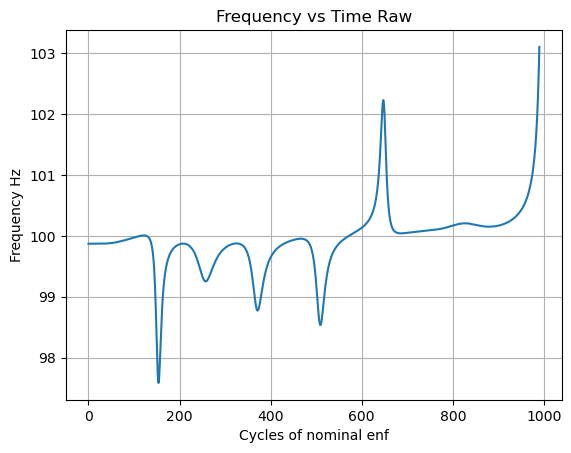

/tmp/ipykernel_12654/3911042346.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  convergence_criteria = np.linalg.norm(
/home/leo_dacasi/Dokumente/summerofcode/ENFify/enfify/enf_estimation.py:89: RuntimeWarning: invalid value encountered in scalar divide
  F_kmax = (np.pi * k_max) / (N_DFT * np.sin(np.pi * k_max / N_DFT))


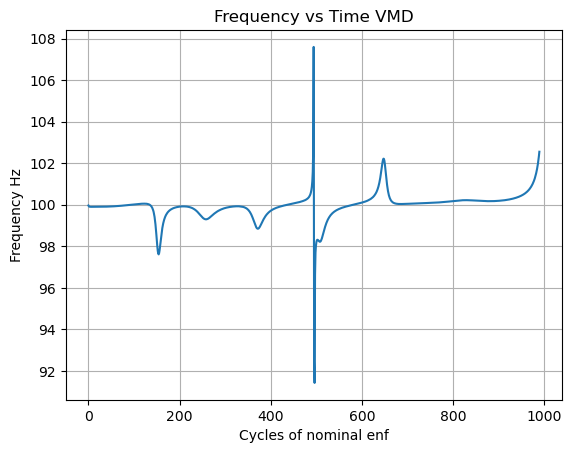

100%|██████████| 1/1 [00:05<00:00,  5.99s/it]


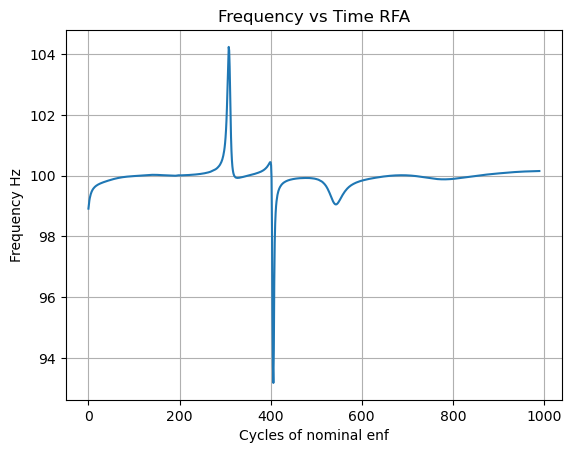

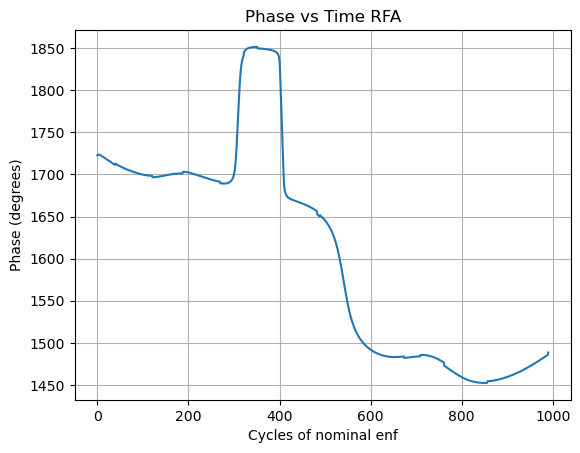

In [23]:
## ENF Preprocessing and enhancement
# Read
pth = os.path.join(UNCUT_PATH, uncut_files[k])
sample_rate, data = wavfile.read(pth)
print(sample_rate)

# Downsampling
down_sig, down_fs = downsample_ffmpeg(data, sample_rate, DOWNSAMPLE_FS)

# Bandpass
band_sig = bandpass_filter(down_sig, BNP_LOW, BNP_HIGH, DOWNSAMPLE_FS, BANDPASS_ORDER)

freqs = segmented_freq_estimation_DFT1(band_sig, DOWNSAMPLE_FS, NUM_CYCLES, N_DFT, F0)
plt.plot(freqs)
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Frequency Hz")
plt.title("Frequency vs Time Raw")
plt.grid(True)
plt.show()


# VMD
for i in range(5):
    u_clean, _, _ = VMD_2(band_sig, ALPHA, TAU, N_MODE, DC, TOL)
    vmd_sig = u_clean[0]

freqs = segmented_freq_estimation_DFT1(vmd_sig, DOWNSAMPLE_FS, NUM_CYCLES, N_DFT, F0)
plt.plot(freqs)
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Frequency Hz")
plt.title("Frequency vs Time VMD")
plt.grid(True)
plt.show()


# RFA
rfa_sig = RFA(vmd_sig, DOWNSAMPLE_FS, TAU_RFA, EPSILON, I, F0)

freqs = segmented_freq_estimation_DFT1(rfa_sig, DOWNSAMPLE_FS, NUM_CYCLES, N_DFT, F0)
plt.plot(freqs)
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Frequency Hz")
plt.title("Frequency vs Time RFA")
plt.grid(True)
plt.show()

phases = segmented_phase_estimation_hilbert(rfa_sig, DOWNSAMPLE_FS, NUM_CYCLES, F0)
phases = np.unwrap(phases)
x = np.arange(len(phases))
plt.plot(x, np.degrees(phases))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time RFA")
plt.grid(True)
plt.show()

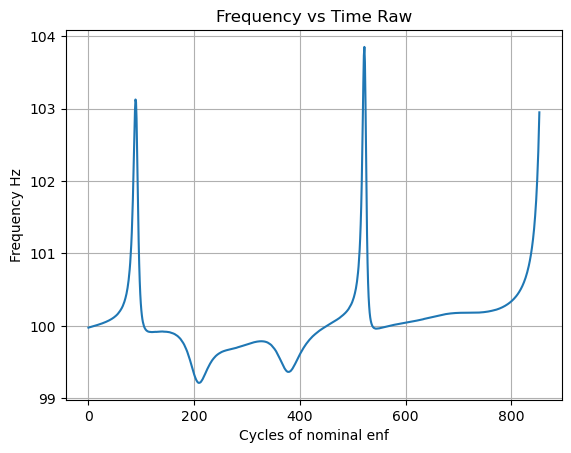

/tmp/ipykernel_12654/3911042346.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  convergence_criteria = np.linalg.norm(


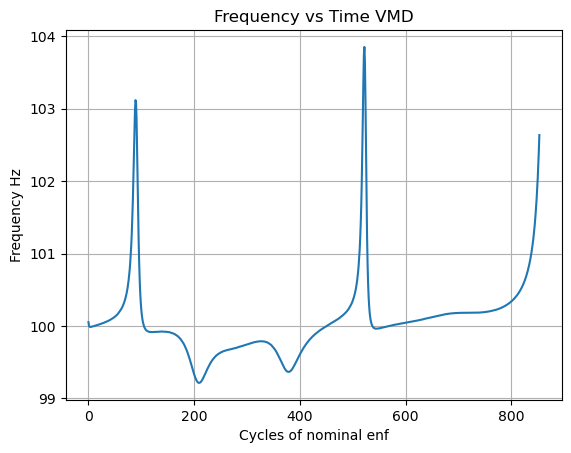

100%|██████████| 1/1 [00:04<00:00,  4.47s/it]


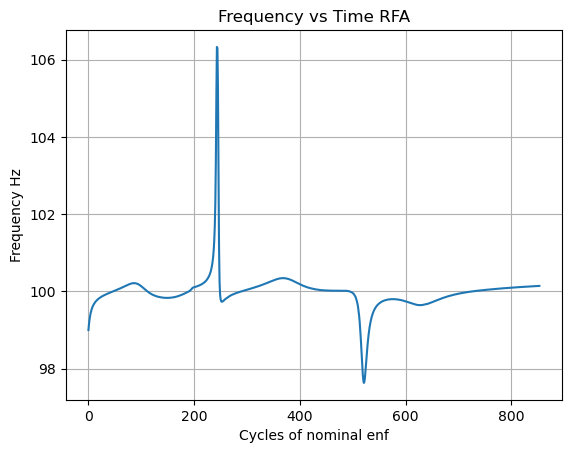

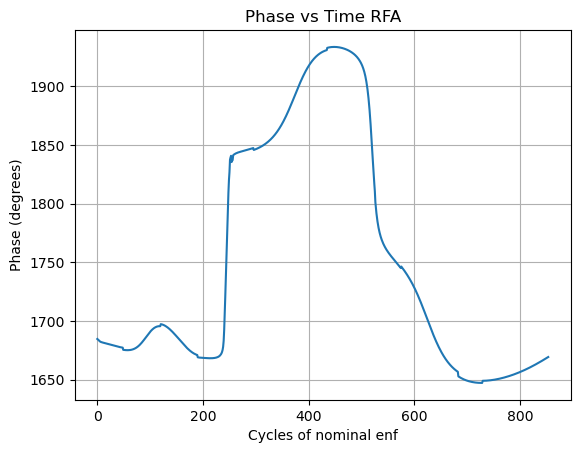

In [24]:
## ENF Preprocessing and enhancement
# Read
pth = os.path.join(CUT_PATH, cut_files[k])
sample_rate, data = wavfile.read(pth)

# Downsampling
down_sig, down_fs = downsample_ffmpeg(data, sample_rate, DOWNSAMPLE_FS)

# Bandpass
band_sig = bandpass_filter(down_sig, BNP_LOW, BNP_HIGH, DOWNSAMPLE_FS, BANDPASS_ORDER)

freqs = segmented_freq_estimation_DFT1(band_sig, DOWNSAMPLE_FS, NUM_CYCLES, N_DFT, F0)
plt.plot(freqs)
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Frequency Hz")
plt.title("Frequency vs Time Raw")
plt.grid(True)
plt.show()


# VMD
for i in range(5):
    u_clean, _, _ = VMD_2(band_sig, ALPHA, TAU, N_MODE, DC, TOL)
    vmd_sig = u_clean[0]

freqs = segmented_freq_estimation_DFT1(vmd_sig, DOWNSAMPLE_FS, NUM_CYCLES, N_DFT, F0)
plt.plot(freqs)
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Frequency Hz")
plt.title("Frequency vs Time VMD")
plt.grid(True)
plt.show()


# RFA
rfa_sig = RFA(vmd_sig, DOWNSAMPLE_FS, TAU_RFA, EPSILON, I, F0)

freqs_cut = segmented_freq_estimation_DFT1(rfa_sig, DOWNSAMPLE_FS, NUM_CYCLES, N_DFT, F0)
plt.plot(freqs_cut)
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Frequency Hz")
plt.title("Frequency vs Time RFA")
plt.grid(True)
plt.show()

phases_cut = segmented_phase_estimation_hilbert(rfa_sig, DOWNSAMPLE_FS, NUM_CYCLES, F0)
phases_cut = np.unwrap(phases_cut)
x = np.arange(len(phases_cut))
plt.plot(x, np.degrees(phases_cut))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time RFA")
plt.grid(True)
plt.show()

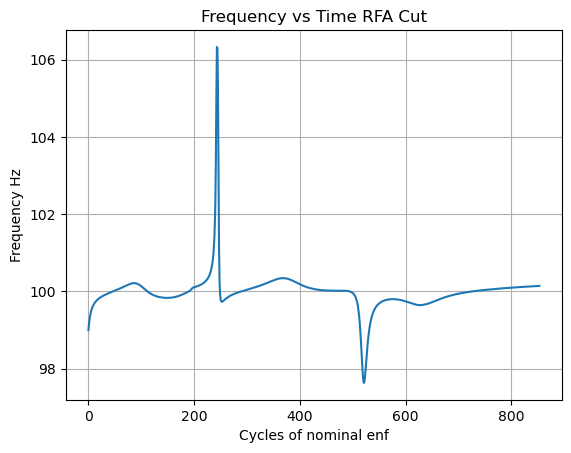

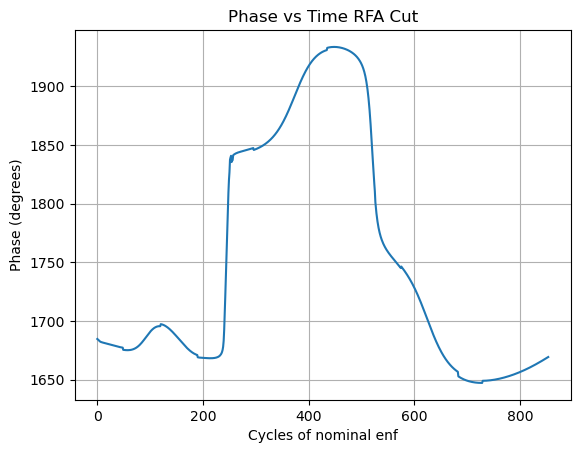

In [25]:
# CUT
plt.plot(freqs_cut)
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Frequency Hz")
plt.title("Frequency vs Time RFA Cut")
plt.grid(True)
plt.show()

plt.plot(x, np.degrees(phases_cut))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time RFA Cut")
plt.grid(True)
plt.show()

# Uncut